In [1]:
import pandas as pd
import numpy as np
from cosine_lr_scheduler import CosineLRScheduler
from custom_tokenizer import BytePairEncodingTokenizer
import re, os, random
from string import punctuation
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
reset_random_seeds()

# load tokenizer
tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')

2025-05-16 19:02:50.802840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 19:02:50.816606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 19:02:50.820801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 19:02:50.830856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 19:02:51.499091: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("/home/bibek/dataset/train.csv")
X = df.text
Y = df.target

In [3]:
def preprocess_text(x,tweet=False):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x)
    
    punct_to_keep = """!,.:#?"-;//%$(){}@^*+<=>\\|'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    x = x + ' '
    return re.sub(r'\s+', ' ', x).strip()

In [4]:
# preprocess, tokenize and pad data

tokenizer.maxlen = 64

X = [preprocess_text(x) for x in tqdm(X)]
X = [tokenizer.tokenize(x) for x in tqdm(X)]
X = np.array([tokenizer.add_padding(x) for x in tqdm(X)],np.int16)

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [5]:
# split data

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.7,random_state=10)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size=0.66,random_state=10)

In [6]:
# training params

MAXLEN = tokenizer.maxlen

PEAK_LR = 2e-4
END_LR = 1e-7
INIT_LR = 0
WARMUP_RATE = 0.05

BATCH = 8
EPOCHS = 3

# load model and its pretrained weights

i1 = tf.keras.layers.Input((MAXLEN,),BATCH)
i2 = tf.keras.layers.Input((MAXLEN-1,),BATCH)

model = tf.keras.models.load_model("robust_net.keras")

i1 = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)
i2 = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)

model([i1,i2])
model.load_weights("robust_net.weights.h5")

I0000 00:00:1747402382.436298    9701 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747402382.462453    9701 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747402382.462728    9701 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747402382.867816    9701 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:

# extract the embedding layer and the encoder block from the original model
# and build an encoder only model

reset_random_seeds()

fact_emb_layer = model.layers[0]
encoder = model.layers[1]

i = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)
x,mask = fact_emb_layer(i)
x = encoder([x,mask])
x = tf.keras.layers.GlobalAveragePooling1D()(x)
o = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,o)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (8, 64)           │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ factorized_embeddi… │ [(8, 64, 256),    │  1,957,760 │ input_layer_4[0]… │
│ (FactorizedEmbeddi… │ (8, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block       │ (8, 64, 256)      │  1,054,208 │ factorized_embed… │
│ (EncoderBlock)      │                   │            │ factorized_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (8, 256)          │          0 │ encoder_block[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (8, 1)            │        257 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,012,225 (11.49 MB)

 Trainable params: 3,012,225 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
@tf.function
def train_step(x,y,model):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y,model):
    pred = model(x,training=False)
    loss = loss_fn(y,pred)
    return loss

In [10]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=BATCH,drop_remainder=True).shuffle(buffer_size=1000)

valid = tf.data.Dataset.from_tensor_slices((xval,yval)).batch(batch_size=BATCH)

test = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=BATCH)

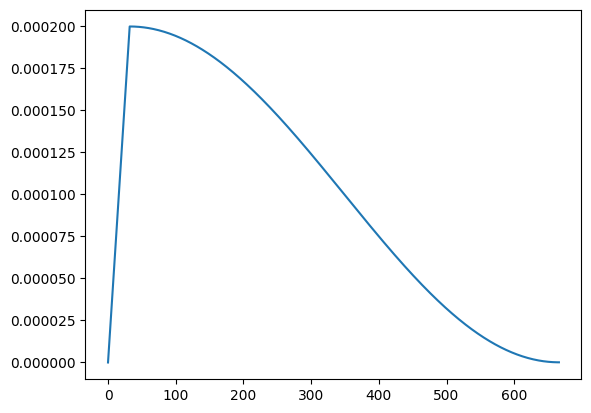

In [11]:
# lr scheduling

total_steps = len(xtrain) // BATCH + 1

lr_scheduler = CosineLRScheduler(total_steps,peak_lr=PEAK_LR,init_lr=INIT_LR,
                                 min_lr=END_LR,warmup_rate=WARMUP_RATE)

plt.plot([lr_scheduler(i) for i in range(1,total_steps+1)])

In [12]:
# start model training


losses = {'train':[],'valid':[]}

for e in range(1,EPOCHS+1):
    
    print(f'EPOCH : {e}/{EPOCHS}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,model)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    
    loss = 0
    for i,(x,y) in enumerate(valid):
        loss += test_step(x,y,model)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'saved_weights.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'saved_weights.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    print()

EPOCH : 1/3


  0%|          | 0/666 [00:00<?, ?it/s]

2025-05-16 19:04:03.103641: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train_loss : 0.4956
val_loss : 0.4113
weights saved

EPOCH : 2/3


2025-05-16 19:04:03.709088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/666 [00:00<?, ?it/s]

train_loss : 0.4113
val_loss : 0.3985
weights saved

EPOCH : 3/3


2025-05-16 19:04:08.887779: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/666 [00:00<?, ?it/s]

train_loss : 0.3591
val_loss : 0.414



In [13]:
model.load_weights('saved_weights.weights.h5')


In [14]:
# metrics for test data

preds = []

for i,(x,y) in enumerate(test):
    mask = x == 0
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(ytest,preds))
print('f1_score :',f1_score(ytest.values,preds))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       856
           1       0.81      0.73      0.77       651

    accuracy                           0.81      1507
   macro avg       0.81      0.80      0.81      1507
weighted avg       0.81      0.81      0.81      1507

f1_score : 0.7715899919289749


In [15]:
# metrics for val data

preds = []

for i,(x,y) in enumerate(valid):
    mask = x == 0
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(yval,preds))
print('f1_score :',f1_score(yval.values,preds))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       459
           1       0.81      0.75      0.78       318

    accuracy                           0.83       777
   macro avg       0.82      0.81      0.82       777
weighted avg       0.83      0.83      0.83       777

f1_score : 0.7797716150081566


2025-05-16 19:04:36.078761: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
